#  To activate MPS on M1 MAC

### 1. Run these in Terminal
```shell
chmod +x ~/Downloads/Miniforge3-MacOSX-arm64.sh
sh ~/Downloads/Miniforge3-MacOSX-arm64.sh
source ~/miniforge3/bin/activate
```

### 2. Create a conda environment :
```bash
mkdir pytorch
cd pytorch
```
### 3. Run these:

```shell
conda create --prefix ./env python=3.8
conda activate ./env
```

### 4.Install torch with MPS backend. Note that torch version should be >= 1.12.0
```bash
pip3 install torch torchvision torchaudio
```
### 5. install other DS libraries:
```bash
conda install jupyter pandas numpy matplotlib 
```
### 6. Run 
```shell
jupyter notebook
```
### 7. test the MPS backend with provided function.




In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import Normalize, ToTensor
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
import matplotlib.pyplot as plt
import argparse
import time
from collections import OrderedDict

In [2]:
def check_backend():
    global device
    print(f" Pytorch Version {torch.__version__}")
    print (f' MPS backend is bulit? {torch.backends.mps.is_built()}')
    print( f' MPS backend is available {torch.backends.mps.is_available()}')
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    print(f' Device is set to {device}')
    return 


# load data in

def load_data(val_split=0.8):
    
    train_set = datasets.EMNIST(root="data", split="balanced", train=True, transform=transforms.Compose([ToTensor()]))
    test_set = datasets.EMNIST(root="data", split="balanced", train=False, transform=transforms.Compose([ToTensor()]))
    train_ = torch.utils.data.DataLoader(train_set, shuffle=True)

    split_ = int(val_split*(len(train_)))  
    valid_ = len(train_) - split_ 

    train_set, val_set = torch.utils.data.random_split(train_set, [split_, valid_]) 

    print(f' train size: {len(train_set)}, val size: {len(val_set)} , test size: {len(test_set)} ')
    classes = test_set.classes
    return train_set, val_set, test_set,classes


In [3]:
check_backend()
train_set, val_set, test_set,classes = load_data(val_split=0.8)


 Pytorch Version 1.12.0
 MPS backend is bulit? True
 MPS backend is available True
 Device is set to mps
 train size: 90240, val size: 22560 , test size: 18800 


In [5]:
OUTPUT_SIZE = len(classes)

In [6]:
# easily tunable model
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu_1 = nn.ReLU()
        
        self.conv_2 =  nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu_2 =  nn.ReLU()
        
        self.max_3  =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_3 =  nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.bn_3   =  nn.BatchNorm2d(128)
        self.relu_3 =  nn.ReLU()
         
        self.out    =  nn.Sequential(nn.Linear(25088, 64),nn.ReLU(),nn.Linear(64, OUTPUT_SIZE))
         
        

    def forward(self, x):
        x = self.conv_1 (x)
        x = self.relu_1 (x)
        
        x = self.conv_2 (x)
        x = self.relu_2 (x)
        
        x = self.max_3  (x)
        x = self.conv_3 (x)
        x = self.bn_3 (x)
        x = self.relu_3(x)
        
        x = torch.flatten(x, 1)
        x = self.out(x)
        
        return x
    
    

# Train, Validate, Test Functions

In [7]:
def train(model, optimizer, criterion):
  
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
    
    model.train()
    
    correct = 0
    total = 0
    train_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        #3inputs, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        
        train_loss += loss.item()
        
        _, prediction = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

    train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return model, train_loss, train_acc  

In [8]:
def validate(model, criterion):

    val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=True)
    
    model.eval()

    correct = 0
    total = 0
    val_loss = 0 
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

    return val_loss, val_acc

In [9]:
def test(model):

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total

    return test_acc

In [10]:
def model_explore(epochs = 2):
 
    model = CNN()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr = 0.001)  
    print(model)


    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    time_total = 0
    
    for epoch in range(epochs): 
        time_start = time.time()
        model, train_loss, train_acc = train(model, optimizer, criterion)
        val_loss, val_acc = validate(model, criterion)
        time_end = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        time_duration = round(time_end - time_start, 2)
        time_total += time_duration
        
      
        print(f'Epoch {epoch},\t train acc: {train_acc:.3f},train loss: {train_loss:.5f},\t val acc: {val_acc:.3f}, val loss: {val_loss:.5f},  \t time: {time_duration}s')
    test_acc = test(model)

    results = OrderedDict()
    results['train_losses'] = [round(x, 4) for x in train_losses]
    results['val_losses'] = [round(x, 4) for x in val_losses]
    results['train_accs'] = [round(x, 2) for x in train_accs]
    results['val_accs'] = [round(x, 2) for x in val_accs]
    results['train_acc'] = round(train_acc, 2)
    results['val_acc'] = round(val_acc, 2)
    results['test_acc'] = round(test_acc, 2)
    results['time_total'] = round(time_total, 2)
    
    return results, model

In [35]:
results,model = model_explore(epochs= 30)

print(f'test acc: {results["test_acc"]}')
print(f'total training time: {results["time_total"]}')
print()

CNN(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (out): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=47, bias=True)
  )
)
Epoch 0,	 train acc: 60.559,train loss: 1.41203,	 val acc: 78.444, val loss: 0.68951,  	 time: 15.45s
Epoch 1,	 train acc: 81.502,train loss: 0.57966,	 val acc: 82.234, val loss: 0.56284,  	 time: 15.67s
Epoch 2,	 train acc: 84.031,train loss: 0.48301,	 val acc: 83.910, val loss: 0.49325,  	 time: 15.52s
Epoch 3,	 train acc: 85.294,train loss: 0.43730,	 val a

In [36]:
torch.save(model.state_dict(),'EMNIST_CNN_model_22JUL2022.pth')

In [37]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('EMNIST_CNN_model_22JUL2022.pth'))


<All keys matched successfully>

In [38]:
loaded_model.eval()


CNN(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (out): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=47, bias=True)
  )
)

In [39]:
model.eval()

CNN(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (out): Sequential(
    (0): Linear(in_features=25088, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=47, bias=True)
  )
)

In [45]:
for i in range(100):

    x,y = test_set[i][0], test_set [i][1]
    x = x.unsqueeze(0)
    with torch.no_grad():
        pred = loaded_model(x)
        predicted , actual = classes[pred[0].argmax(0)],classes[y]
        if  predicted != actual:
            flag = 'Not correct'
        else :
             flag = ''
        print(f'Imgae {i}, preicted : "{predicted}", actual:"{actual}" \t {flag}')

Imgae 0, preicted : "g", actual:"g" 	 
Imgae 1, preicted : "e", actual:"e" 	 
Imgae 2, preicted : "9", actual:"9" 	 
Imgae 3, preicted : "Q", actual:"Q" 	 
Imgae 4, preicted : "q", actual:"q" 	 
Imgae 5, preicted : "X", actual:"X" 	 
Imgae 6, preicted : "E", actual:"E" 	 
Imgae 7, preicted : "B", actual:"B" 	 
Imgae 8, preicted : "3", actual:"3" 	 
Imgae 9, preicted : "L", actual:"C" 	 Not correct
Imgae 10, preicted : "G", actual:"G" 	 
Imgae 11, preicted : "7", actual:"7" 	 
Imgae 12, preicted : "Z", actual:"2" 	 Not correct
Imgae 13, preicted : "G", actual:"G" 	 
Imgae 14, preicted : "0", actual:"G" 	 Not correct
Imgae 15, preicted : "R", actual:"R" 	 
Imgae 16, preicted : "6", actual:"6" 	 
Imgae 17, preicted : "8", actual:"q" 	 Not correct
Imgae 18, preicted : "S", actual:"S" 	 
Imgae 19, preicted : "r", actual:"r" 	 
Imgae 20, preicted : "T", actual:"T" 	 
Imgae 21, preicted : "8", actual:"8" 	 
Imgae 22, preicted : "4", actual:"4" 	 
Imgae 23, preicted : "Z", actual:"Z" 	 
Imgae 

In [43]:
# Using this function you can see the image and its label form the dataset
def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")


Label: (C)


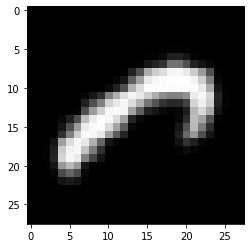

In [56]:
show_example(test_set[9])

In [49]:
from torchvision.utils import make_grid


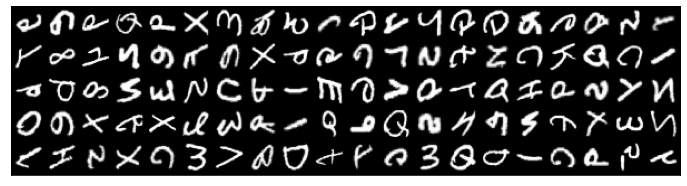

In [55]:
def show_batch(dl):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)
    for images, labels in test_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
        
show_batch(test_set)